## UNet

### Read Data

In [ ]:
# link to file address
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
from PIL import Image 
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, utils, transforms
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import glob
import re

In [ ]:
# build the class to read data 
# input of class FDLDataset: 
# no need to input image path
# split desides to use train/validation/test data, where test is not used in this program since we don't have the label of test set
class FDL21Dataset(Dataset):
    def __init__(self, split, root_dir, target_type='semantic', transform=None, eval=False):
        self.transform = transform
        self.split = split
        self.eval = eval

        # Preparing a list of all images and masks rgb and 
        # ground truth images. Setting relabbelled=True is recommended. 

        # in this project, only use the else session since there is no test label provided
        if self.split == 'test':
          self.yLabel_list = sorted(glob.glob('/content/gdrive/MyDrive/Kaggle Deep Learning/test_images/'+'*.jpg')) # use glob and re to get image
          self.XImg_list = sorted(glob.glob('/content/gdrive/MyDrive/Kaggle Deep Learning/test_images/'+'*.jpg'))
          self.df = pd.DataFrame(list(zip(self.XImg_list, self.yLabel_list)), columns=['image','y']) # use zip to create list and list them again to make dataframe
        else:   
          self.yLabel_list = sorted(glob.glob('/content/gdrive/MyDrive/Kaggle Deep Learning/train_masks/'+'*.png'))
          self.XImg_list = sorted(glob.glob('/content/gdrive/MyDrive/Kaggle Deep Learning/train_images/'+'*.jpg'))
          self.df = pd.DataFrame(list(zip(self.XImg_list, self.yLabel_list)), columns=['image','y'])
          train_df, valid_df = train_test_split(self.df, test_size = 0.15, random_state = 42)
          # decide to get train data or validation data
          if self.split == 'train':
            self.df = train_df
          elif self.split == 'val':
            self.df = valid_df

    def __len__(self):
        length = len(self.df.image)
        return length
      

    def __getitem__(self, index):
        # use pandas and numpy to get image and label from df made in __init__
        image = Image.open(self.df.iloc[index].image)
        y = Image.open(self.df.iloc[index].y)

        # use transform to image when transform is defined 
        # since here is a mistake since we don't have to transform label(y)
        if self.transform is not None:
            image = self.transform(image)
            y = self.transform(y)

        # transform both iamge and label to tensor
        image = transforms.ToTensor()(image)
        y = np.array(y)
        y = torch.from_numpy(y)

        # change labels to be int for classification
        y = y.type(torch.LongTensor) 
        if self.eval:
            return image, y, self.df.iloc[index].image
        else:
            return image, y

In [ ]:
# Function to get data and transform it to dataloader
def get_FDL21_data(
    split,
    root_dir='/content/gdrive/MyDrive/Kaggle Deep Learning/',
    target_type="semantic",
    transforms=None,
    batch_size=8,
    eval=False,
    shuffle=True,
    pin_memory=True,

):
    data = FDL21Dataset(
        split=split, target_type=target_type, transform=transforms, root_dir=root_dir, eval=eval)

    data_loaded = torch.utils.data.DataLoader(
        data, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)

    return data_loaded

# Functions to save predictions as images 
def save_as_images(tensor_pred, folder, image_name):
    tensor_pred = transforms.ToPILImage()(tensor_pred.byte())
    filename = os.path.join(folder, image_name+'.png')
    tensor_pred.save(filename)

### Define Model

*U-Net: Convolutional Networks for Biomedical
Image Segmentation*

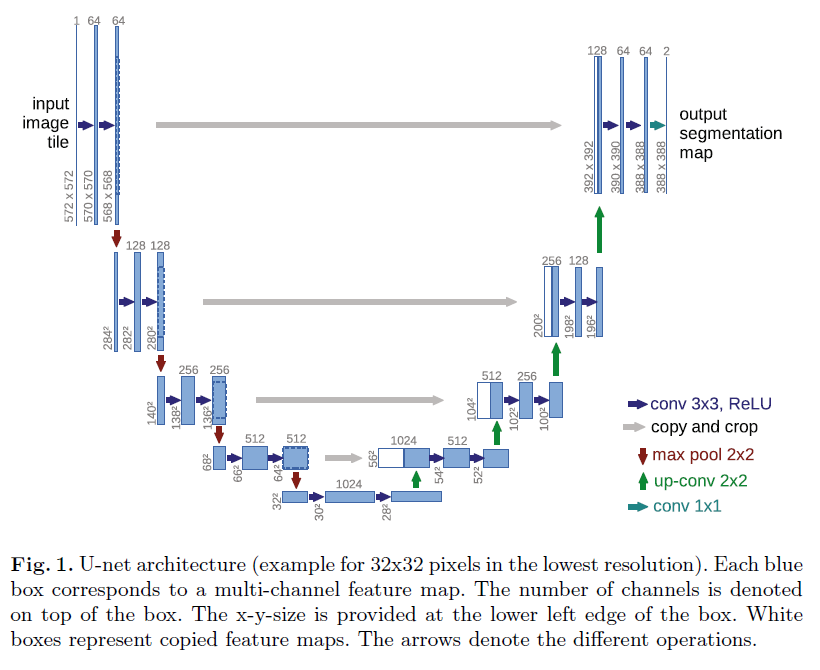

In [ ]:
# define the size of each transformed iamge and each transformed label
# pre defined since it would be used in the class UNet
IMG_HEIGHT = 512  
IMG_WIDTH = 512 

In [ ]:
import torch
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Dropout
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torch.nn import functional as F
from torchvision.transforms import CenterCrop

# define a nn module included conv, relu and conv as block which would be used for times in the UNet structure
class Block(Module):
	def __init__(self, in_channels, out_channels):
		super().__init__()
		# store the convolution and RELU layers
		# here 3 means the kernal, better to add padding = 1 to add number to pixels which cannot be kernaled
		self.conv1 = Conv2d(in_channels, out_channels, 3) 
		# here relu change units to 0 and positive numbers
		self.relu = ReLU()
		# conv again
		self.conv2 = Conv2d(out_channels, out_channels, 3)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

# define a nn module which used to extract features from images in different level (when 16 channels, features in 2*2 pixels level
# 																										when 32 channels, features in 4*4 pixels level
# 																										when 64 channels, features in 8*8 pixels level)
# level changed because after every block we use maxpool to resample the image
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		# enc_blocks means several (input_channel, output_channel) tuples of block defined before, a kind of neural network
		self.enc_blocks = ModuleList([Block(channels[i], channels[i + 1])
			 	            for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		block_outputs = []
		# loop through the encoder blocks
		for block in self.enc_blocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			block_outputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return block_outputs

# define a nn module which upconv the final result of the encoder (64 channels with features in 8*8 pixels level)
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList([ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	          for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList([Block(channels[i], channels[i + 1])
			 	          for i in range(len(channels) - 1)])
	def forward(self, x, enc_features):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			enc_feat = self.crop(enc_features[i], x)
			x = torch.cat([x, enc_feat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, enc_features, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		enc_features = CenterCrop([H, W])(enc_features)
		# return the cropped features
		return enc_features

# define nn class UNet
# we first do encoding to get features for 3 times in different level 
# then we upconv the result of the encoding result for three times
# every time after upconv, we concrete the upconv result and previous encoder result, thus we get channels with the same features level
# this helps us to get features in different level
# for example, features in different level for a image includes 2*2, 4*4, 8*8, and in every level, we have basic encode featues and upconv features
# as a result, to determine the class of every pixel, we know the information around this pixel and meanwhile we know the distirt around it
class UNet(Module):
  def __init__(self, enc_channels=(3, 16, 32, 64), dec_channels = (64, 32, 16), 
          nb_classes = 25, retain_dim = True, 
          out_size = (IMG_HEIGHT, IMG_WIDTH)):
    super().__init__()
    # initialize the encoder and decoder
    self.encoder = Encoder(enc_channels)
    self.decoder = Decoder(dec_channels)
    # initialize the regression head and store the class variables
    self.head = Conv2d(dec_channels[-1], nb_classes, 1)
    self.retain_dim = retain_dim
    self.out_size = out_size
    self.pool = MaxPool2d(2,padding = 1)
  def forward(self, x):
    # grab the features from the encoder
    enc_features = self.encoder(x)
    # pass the encoder features through decoder making sure that
    # their dimensions are suited for concatenation
    dec_features = self.decoder(enc_features[::-1][0], enc_features[::-1][1:])
    # pass the decoder features through the regression head to
    # obtain the segmentation mask
    map = self.head(dec_features)
    # check to see if we are retaining the original output
    # dimensions and if so, then resize the output to match them
    if self.retain_dim:
        map = F.interpolate(map, self.out_size)
    # return the segmentation map
    return map

### Pre Setting

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

if torch.cuda.is_available():
    DEVICE = 'cuda:0'
    print('Running on the GPU')
else:
    DEVICE = "cpu"
    print('Running on the CPU')

MODEL_PATH = '/content/gdrive/MyDrive/Kaggle Deep Learning/output/UNetBasic.pth'
LOAD_MODEL = False
ROOT_DIR = '/content/gdrive/MyDrive/Kaggle Deep Learning/'
IMG_HEIGHT = 512  
IMG_WIDTH = 512  
BATCH_SIZE = 8
LEARNING_RATE = 0.0005
EPOCHS = 20


Running on the GPU


### Training

In [ ]:
def train_function(data, model, optimizer, loss_fn, device):
    print('Entering into train function')
    loss_values = []
    data = tqdm(data)
    for index, batch in enumerate(data): 
        optimizer.zero_grad()
        X, y = batch
        X, y = X.to(device), y.to(device)

        preds = model(X)
        loss = loss_fn(preds, y)

        loss.backward()
        optimizer.step()

    return loss.item()

In [ ]:
def validation_function(data, model, loss_fn, device):
    model.eval()
    validation_loss_values = []
    
    data = tqdm(data)
    for index, batch in enumerate(data): 
        X, y = batch
        X, y = X.to(device), y.to(device)

        preds = model(X)
        validation_loss = loss_fn(preds, y)

        validation_loss_values.append(validation_loss.item())
    
    return validation_loss_values

In [ ]:
global epoch
epoch = 0 # epoch is initially assigned to 0. If LOAD_MODEL is true then
          # epoch is set to the last value + 1. 
LOSS_VALS = [] # Defining a list to store loss values after every epoch
VALIDATION_LOSS = []

transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=transforms.InterpolationMode.NEAREST),
]) 

train_set = get_FDL21_data(
    split='train',
    root_dir=ROOT_DIR,
    transforms=transform,
    batch_size=BATCH_SIZE,
)

validation_set = get_FDL21_data(
    split='val',
    root_dir=ROOT_DIR,
    transforms=transform,
    batch_size=BATCH_SIZE,
)

In [ ]:
train_set

In [ ]:
# Defining the model, optimizer and loss function
unet = UNet().to(DEVICE)
optimizer = optim.SGD(unet.parameters(), lr=LEARNING_RATE)
loss_function = torch.nn.CrossEntropyLoss() 

In [ ]:
import matplotlib.pyplot as plt
save_folder = '/content/gdrive/MyDrive/Kaggle Deep Learning/output/'
#function that creates the train-val loss graph
#variables 'train_loss' and 'val_loss' are losts containing the average losses for all the epochs
def save_graph(train_loss, val_loss, nb_epochs, save_folder):
    plt.plot(list(range(nb_epochs+1))[1:], train_loss)
    plt.plot(list(range(nb_epochs+1))[1:], val_loss)
    plt.legend(['train', 'val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('{}/chart.png'.format(save_folder))

In [ ]:
#Training the model for every epoch. 
for e in range(epoch, EPOCHS):
    ## TRAINING ##
    print(f'Epoch: {e}')
    loss_val = train_function(train_set, unet, optimizer, loss_function, DEVICE)
    LOSS_VALS.append(loss_val) 
    torch.save({
        'model_state_dict': unet.state_dict(),
        'optim_state_dict': optimizer.state_dict(),
        'epoch': e,
        'loss_values': LOSS_VALS
    }, MODEL_PATH)
    print("Epoch completed and model successfully saved!")

    ## VALIDATION ##
    validation_loss_values = validation_function(validation_set, unet, loss_function, DEVICE)
    validation_loss_mean = np.mean(validation_loss_values)
    VALIDATION_LOSS.append(validation_loss_mean)

Epoch: 0
Entering into train function


100%|██████████| 28/28 [00:55<00:00,  1.97s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


Epoch: 1
Entering into train function


100%|██████████| 28/28 [00:54<00:00,  1.95s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


Epoch: 2
Entering into train function


100%|██████████| 28/28 [00:54<00:00,  1.96s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


Epoch: 3
Entering into train function


100%|██████████| 28/28 [00:54<00:00,  1.95s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


Epoch: 4
Entering into train function


100%|██████████| 28/28 [00:54<00:00,  1.95s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


Epoch: 5
Entering into train function


100%|██████████| 28/28 [00:54<00:00,  1.95s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


Epoch: 6
Entering into train function


100%|██████████| 28/28 [00:55<00:00,  1.97s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.04s/it]


Epoch: 7
Entering into train function


100%|██████████| 28/28 [00:55<00:00,  1.97s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch: 8
Entering into train function


100%|██████████| 28/28 [00:54<00:00,  1.96s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


Epoch: 9
Entering into train function


100%|██████████| 28/28 [00:54<00:00,  1.94s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.00s/it]


Epoch: 10
Entering into train function


100%|██████████| 28/28 [00:54<00:00,  1.93s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


Epoch: 11
Entering into train function


100%|██████████| 28/28 [00:54<00:00,  1.94s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.00s/it]


Epoch: 12
Entering into train function


100%|██████████| 28/28 [00:54<00:00,  1.94s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


Epoch: 13
Entering into train function


100%|██████████| 28/28 [00:54<00:00,  1.94s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


Epoch: 14
Entering into train function


100%|██████████| 28/28 [00:54<00:00,  1.93s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


Epoch: 15
Entering into train function


100%|██████████| 28/28 [00:54<00:00,  1.94s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


Epoch: 16
Entering into train function


100%|██████████| 28/28 [00:55<00:00,  1.97s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.00s/it]


Epoch: 17
Entering into train function


100%|██████████| 28/28 [00:55<00:00,  1.97s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:09<00:00,  2.00s/it]


Epoch: 18
Entering into train function


100%|██████████| 28/28 [00:54<00:00,  1.94s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


Epoch: 19
Entering into train function


100%|██████████| 28/28 [00:54<00:00,  1.94s/it]


Epoch completed and model successfully saved!


100%|██████████| 5/5 [00:10<00:00,  2.00s/it]


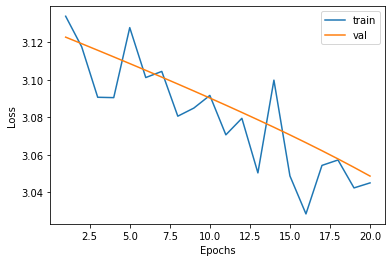

In [ ]:
save_graph(LOSS_VALS, VALIDATION_LOSS, EPOCHS, save_folder)

### Predict and Output

In [ ]:
torch.cuda.empty_cache()

In [ ]:
folder = '/content/gdrive/MyDrive/Kaggle Deep Learning/test_masks'

In [ ]:
import matplotlib.pyplot as plt 

Running on the GPU
Data has been loaded!
/content/gdrive/MyDrive/Kaggle Deep Learning/output/UNetBasic.pth has been loaded and initialized


100%|██████████| 112/112 [00:59<00:00,  1.89it/s]

loss:
3.2149319648742676


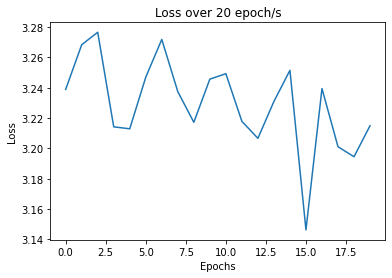

In [ ]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Running on the GPU')
else:
    device = 'cpu'
    print('Running on the CPU')
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
EVAL = True
PLOT_LOSS = True

def save_predictions(data, model):    
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(data)):

            X, y, s = batch # here 's' is the name of the file stored in the root directory
            X, y = X.to(device), y.to(device)
            predictions = model(X) 
            
            predictions = torch.nn.functional.softmax(predictions, dim=1)
            pred_labels = torch.argmax(predictions, dim=1) 
            pred_labels = pred_labels.float()

            # Resizing predicted images too original size
            pred_labels = transforms.Resize((4000, 3000), interpolation=transforms.InterpolationMode.NEAREST)(pred_labels)
            # Configure filename & location to save predictions as images
            name = re.search('\/(\d+\.?\d*)\.', str(s)).group(1)
            global location
            #for test: 
            location = '/content/gdrive/MyDrive/Kaggle Deep Learning/test_masks'
            #for val: location = '/content/data/val_preds/'
            save_as_images(pred_labels, location, name)                

def evaluate(path):
    T = transforms.Compose([
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=transforms.InterpolationMode.NEAREST)
    ])

    val_set = get_FDL21_data(
        root_dir=ROOT_DIR,
        split='test',
        transforms=T,
        shuffle=True,
        eval=True
    )
 
    print('Data has been loaded!')

    net = UNet().to(device)
    checkpoint = torch.load(path)
    net.load_state_dict(checkpoint['model_state_dict'])
    net.eval()
    print(f'{path} has been loaded and initialized')
    save_predictions(val_set, net)

def plot_losses(path):
    checkpoint = torch.load(path)
    losses = checkpoint['loss_values']
    epoch = checkpoint['epoch']
    epoch_list = list(range(epoch+1))

    print('loss:')
    print(losses[-1])
    plt.plot(epoch_list, losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f"Loss over {epoch+1} epoch/s")
    plt.show()

if __name__ == '__main__':
    if EVAL:
        evaluate(MODEL_PATH)
    if PLOT_LOSS:
        plot_losses(MODEL_PATH)

In [ ]:
import matplotlib.pyplot as plt 
import cv2

image_path = '/content/gdrive/MyDrive/Kaggle Deep Learning/test_images/10171.jpg'
mask_path = '/content/gdrive/MyDrive/Kaggle Deep Learning/test_masks/10171.png'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
import os

from PIL import Image
import numpy as np

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles():
    """Used for Kaggle submission: predicts and encode all test images"""
    dir = '/content/gdrive/MyDrive/Kaggle Deep Learning/test_masks'
    N = len(list(os.listdir(dir)))
    with open('/content/gdrive/MyDrive/Kaggle Deep Learning/output/submission_file.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in enumerate(os.listdir(dir)):
            print('{}/{}'.format(index, N))

            mask = Image.open(dir + '/' + i)
            mask = mask.resize((1024, 1024), resample=Image.NEAREST)
            mask = np.array(mask)

            for x in range(1, 25):
                enc = rle_encode(mask == x)
                f.write(f"{i.split('_')[0]}_{x},{enc}\n")

In [ ]:
create_rles()